<a href="https://colab.research.google.com/github/nyp-sit/iti107/blob/main/session-2/xception_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

Welcome to this week's programming exercise. In this week's exercises, we will learn how to improve our model performance using common tecniques such as data augmentation and transfer learning. 

Data augmentation is typically used when you have a small set of training samples. It allows you to increase your number of samples by generating artificial samples, either based on some random transformation of your existing samples, or by some statistical means. The larger training samples can help the model to generalize better. 


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

C:\Users\markk\miniconda3\envs\dlenv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Create train and validation dataset

We will go ahead and prepare our train and validation dataset (the cats vs dogs dataset) as before. 

In [2]:
import os 

# dataset_URL = 'https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/datasets/cats_and_dogs_subset.tar.gz'
# tf.keras.utils.get_file(origin=dataset_URL, extract=True, cache_dir='.')
# dataset_folder = os.path.join('datasets', 'cats_and_dogs_subset')

In [3]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
path_to_zip = tf.keras.utils.get_file(origin=dataset_url, extract=True, cache_dir='.')

In [4]:
dataset_folder = os.path.dirname(path_to_zip)
dataset_folder = os.path.join(dataset_folder, 'flower_photos')
pos_path = os.path.join(dataset_folder, 'positive')
neg_path = os.path.join(dataset_folder, 'negative')

In [5]:
print(dataset_folder)

.\datasets\flower_photos


In [6]:
batch_size = 16
image_size = (128,128)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
val_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Data Augmentation 

Since tensorflow 2.2, Keras introduces new types of layers for doing image data augmentation, such as Random Cropping, Random Flipping, etc. Previously, we have to depend on ImageDataGenerator() (which is a lot slower) to do so. 

In the code below, we create a Sequential model to add the image augmentation layer: `RandomRotation()`. The value `0.1' refers to the maximum rotation angle in both clock-wise and anti-clockwise direction. You can find out more info from the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation)

In [8]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomRotation(0.1),
    ]
)

To see the effects of data augmentation, let us apply our data_augmentation layer to a sample image.

(1, 128, 128, 3)


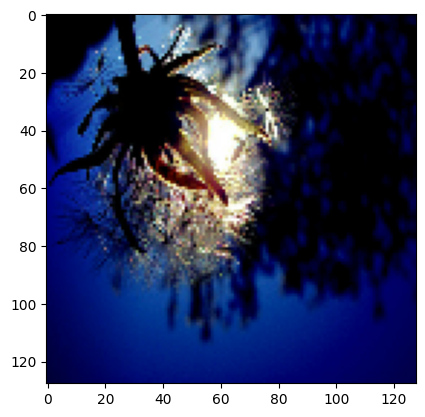

In [9]:
images, _ = next(train_ds.take(1).as_numpy_iterator())
sample_image = images[0]/255.
plt.imshow(sample_image)
sample_image = tf.expand_dims(sample_image, 0)
print(sample_image.shape)

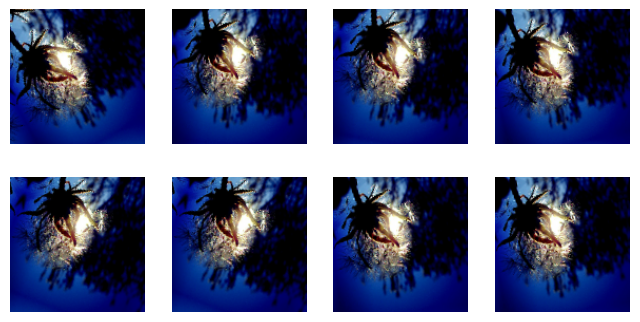

In [10]:
plt.figure(figsize=(8, 4))
for i in range(8):
    augmented_image = data_augmentation(sample_image)
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

**Exercise 1:**

Modify the code above to add in random Horizontal flip Choose the appropriate values for the contrast and cropping factor.

<details><summary>Click here for answer</summary>

```python
    
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.1),
        layers.RandomFlip("horizontal")
    ]
)    
```
    
</details>

In [11]:
## TODO: Modify the code to add data augmentation
data_augmentation = keras.Sequential(
        [
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomFlip("horizontal")
        ]
    )

## Build the model

Previously we have built the mini-Xception network and use it on our small cats and dogs dataset. It performs slightly better than the first simple model we built, but not much of an improvement. Here we will use the same network but adds in the data augmnetation to see if our model can be improved further. 

The following codes are same as previous xception network that you have coded. 


In [12]:
def xception_block(x, depth): 
    # save input to be used as skip connection
    residual = x
    
    # add the first separable convolutional 2D layer (as well as the batch normalization and activation layer)
    x = keras.layers.SeparableConv2D(depth, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    # add the second separable convolutional 2D layer (as well as the batch normalization BUT without activation layer)
    x = keras.layers.SeparableConv2D(depth, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    # add the maxpooling 2d layer, with stride of 2
    x = keras.layers.MaxPool2D(3, strides=2, padding='same')(x)
    
    # adjust the size and depth using 1x1 convolution to match the output from last maxpooling layer. Use strides=2 to match the output from maxpooling
    residual = keras.layers.Conv2D(depth, 1, strides=2, padding='same')(residual)
    
    # add back the residual to the output from maxpooling layer
    x = keras.layers.add( [x, residual] )
    
    # add the activation layer
    x = keras.layers.Activation('relu')(x)
    
    return x # Set aside next residual


**Exercise 2:**

Modify the code in `make_model()` to apply data augmention layers you have created earlier. Where should you place your augmentation layer?  

<details><summary>Click here for answer</summary>

```python
def make_model(input_shape, num_classes): 
    inputs = keras.Input(shape=input_shape)    
    
    ## Add your augmentation layers here !! 
    x = data_augmentation(inputs) 

    x = layers.Rescaling(1.0 / 255)(inputs)

    ## the rest of the codes.... 
    
    return keras.Model(inputs, outputs)    
```
    
</details>

In [13]:
def make_model(input_shape, num_classes): 

    inputs = keras.Input(shape=input_shape)

    ## Add your augmentation layers here !! 
    x = data_augmentation(inputs) 

    # add resclaing 
    x = keras.layers.Rescaling(1./255)(x)
    
    # Entry blocks

    # 1st conv2d with strides = 2
    x = keras.layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # 2nd conv2d with strides = 1
    x = keras.layers.Conv2D(64, 3, strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    # build a series of xception blocks with different depth
    for depth in [128, 256, 512, 728]:
        x = xception_block(x, depth)
    
    # add SeparableConv2D
    x = keras.layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    # add Global Average Pooling layer before connecting to Dense layer 
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    x = keras.layers.Dropout(0.5)(x)
    
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)

In [14]:
model = make_model(input_shape= image_size + (3,), num_classes=5)

## Train the model

Let's train our new model with the data augmentation layer.  We increase our training epochs to 50 to give our model more chances to see the augmented images.

In [ ]:
def create_tb_callback(): 

    import os
    
    root_logdir = os.path.join(os.curdir, "tb_logs")

    def get_run_logdir():    # use a new directory for each run
        
        import time
        
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()

    tb_callback = tf.keras.callbacks.TensorBoard(run_logdir)

    return tb_callback

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_checkpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


# compile our model with loss and optimizer 
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


model.fit(
    train_ds, epochs=50, 
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback, create_tb_callback()]
)

C:\Users\markk\miniconda3\envs\dlenv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/50
184/184 [==============================] - 30s 119ms/step - loss: 1.3052 - accuracy: 0.4847 - val_loss: 2.2824 - val_accuracy: 0.2493
Epoch 2/50
184/184 [==============================] - 20s 107ms/step - loss: 1.0593 - accuracy: 0.5995 - val_loss: 3.7500 - val_accuracy: 0.2493
Epoch 3/50
184/184 [==============================] - 20s 108ms/step - loss: 0.9283 - accuracy: 0.6482 - val_loss: 1.9936 - val_accuracy: 0.3747
Epoch 4/50
184/184 [==============================] - 20s 108ms/step - loss: 0.8789 - accuracy: 0.6693 - val_loss: 0.7907 - val_accuracy: 0.7125
Epoch 5/50
184/184 [==============================] - 20s 109ms/step - loss: 0.7979 - accuracy: 0.7013 - val_loss: 1.0128 - val_accuracy: 0.6376
Epoch 6/50
184/184 [==============================] - 20s 109ms/step - loss: 0.7539 - accuracy: 0.7170 - val_loss: 0.8442 - val_accuracy: 0.7071
Epoch 7/50
184/184 [==============================] - 20s 109ms/step - loss: 0.7226 - accuracy: 0.7309 - val_loss: 0.7522 - val_ac

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb_logs

In [1]:
best_checkpoint = 'best_checkpoint'

model.load_weights(best_checkpoint)
model.evaluate(val_ds)

NameError: name 'model' is not defined